In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [ ]:

excel_file = pd.ExcelFile('/content/E-commerce_data.xlsx')

customers_df = pd.read_excel(excel_file, sheet_name='customers')
genders_df = pd.read_excel(excel_file, sheet_name='genders')
cities_df = pd.read_excel(excel_file, sheet_name='cities')
transactions_df = pd.read_excel(excel_file, sheet_name='transactions')
branches_df = pd.read_excel(excel_file, sheet_name='branches')
merchants_df = pd.read_excel(excel_file, sheet_name='merchants')

customers_full_df = pd.merge(customers_df, genders_df, how='left', on='gender_id')
customers_full_df = pd.merge(customers_full_df, cities_df, how='left', on='city_id')

transactions_full_df = pd.merge(transactions_df, customers_full_df, how='left', on='customer_id')

branches_full_df = pd.merge(branches_df, merchants_df, how='left', on='merchant_id')
final_merged_df = pd.merge(transactions_full_df, branches_full_df, how='left', on='branch_id')



In [ ]:
final_merged_df.head()

,transaction_id,customer_id,transaction_date,transaction_status,coupon_name,burn_date,branch_id,join_date,city_id,gender_id,gender_name,city_name,merchant_id,merchant_name
0,1,733,2024-05-11,subscribed,uNY-568,NaT,7,2023-05-16,15,2,Female,Aswan,7,Berry-Anderson
1,2,631,2023-05-15,burned,kBx-219,2023-06-04,5,2022-10-10,14,2,Female,Damietta,9,"Campbell, Shaffer and Martinez"
2,3,309,2022-11-13,subscribed,PLG-122,NaT,7,2022-05-30,2,1,Male,Alexandria,7,Berry-Anderson
3,4,695,2024-01-26,subscribed,Wzf-897,NaT,2,2023-11-27,15,2,Female,Aswan,18,Lewis LLC
4,5,288,2022-10-12,burned,qGb-428,2022-11-20,6,2021-09-04,14,1,Male,Damietta,15,Butler-Gomez


In [ ]:
final_merged_df.isnull().sum()

,0
transaction_id,0
customer_id,0
transaction_date,0
transaction_status,0
coupon_name,0
burn_date,2484
branch_id,0
join_date,0
city_id,0
gender_id,0


In [ ]:
final_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   transaction_id      5000 non-null   int64         
 1   customer_id         5000 non-null   int64         
 2   transaction_date    5000 non-null   datetime64[ns]
 3   transaction_status  5000 non-null   object        
 4   coupon_name         5000 non-null   object        
 5   burn_date           2516 non-null   datetime64[ns]
 6   branch_id           5000 non-null   int64         
 7   join_date           5000 non-null   datetime64[ns]
 8   city_id             5000 non-null   int64         
 9   gender_id           5000 non-null   int64         
 10  gender_name         5000 non-null   object        
 11  city_name           5000 non-null   object        
 12  merchant_id         5000 non-null   int64         
 13  merchant_name       5000 non-null   object      

In [ ]:
# Check unique values in transaction_status
print(final_merged_df['transaction_status'].unique())

# Create a binary column indicating whether the coupon was burnt or not
final_merged_df['coupon_burnt'] = final_merged_df['transaction_status'].apply(lambda x: 1 if x == 'burned' else 0)

# Display the updated DataFrame
print(final_merged_df[['transaction_status', 'coupon_burnt']].head())


['subscribed' 'burned']
  transaction_status  coupon_burnt
0         subscribed             0
1             burned             1
2         subscribed             0
3         subscribed             0
4             burned             1


In [ ]:
df = final_merged_df.copy()
df.drop(['transaction_status','burn_date','gender_name','merchant_name','city_name','coupon_name'], axis=1, inplace=True)
df.head()

,transaction_id,customer_id,transaction_date,branch_id,join_date,city_id,gender_id,merchant_id,coupon_burnt
0,1,733,2024-05-11,7,2023-05-16,15,2,7,0
1,2,631,2023-05-15,5,2022-10-10,14,2,9,1
2,3,309,2022-11-13,7,2022-05-30,2,1,7,0
3,4,695,2024-01-26,2,2023-11-27,15,2,18,0
4,5,288,2022-10-12,6,2021-09-04,14,1,15,1


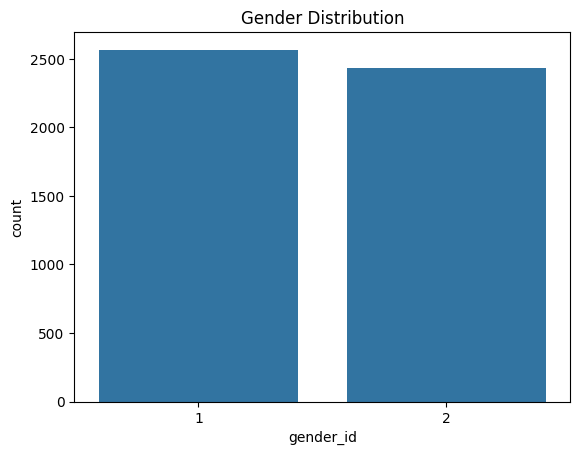

In [ ]:
sns.countplot(x='gender_id', data=df)
plt.title('Gender Distribution')
plt.show()

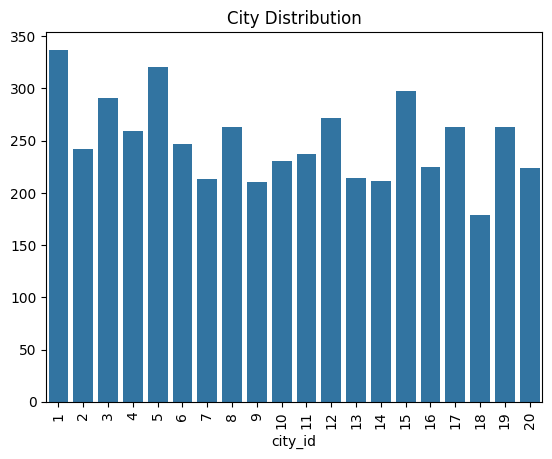

In [ ]:
city_counts = df['city_id'].value_counts()
sns.barplot(x=city_counts.index, y=city_counts.values)
plt.title('City Distribution')
plt.xticks(rotation=90)
plt.show()

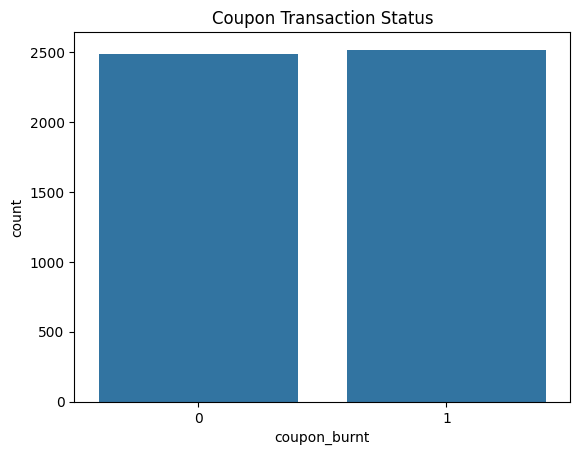

In [ ]:
sns.countplot(x='coupon_burnt', data=df)
plt.title('Coupon Transaction Status')
plt.show()

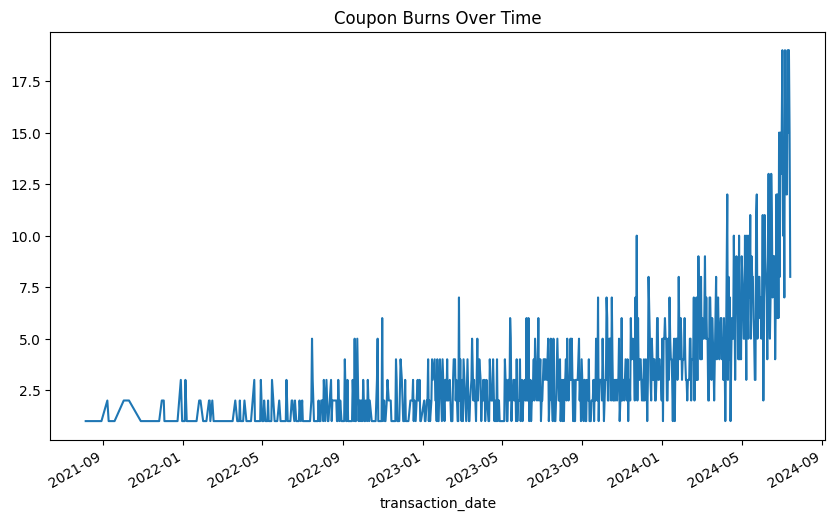

In [ ]:
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
burn_rate_over_time = df[df['coupon_burnt'] == 1 ].groupby('transaction_date').size()
burn_rate_over_time.plot(figsize=(10, 6))
plt.title('Coupon Burns Over Time')
plt.show()

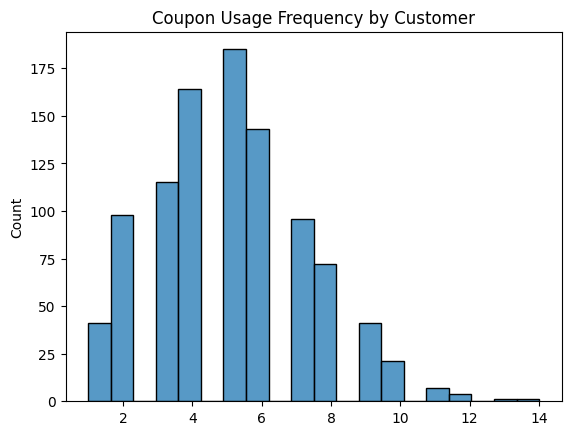

In [ ]:
customer_usage = df.groupby('customer_id').size()
sns.histplot(customer_usage, bins=20)
plt.title('Coupon Usage Frequency by Customer')
plt.show()

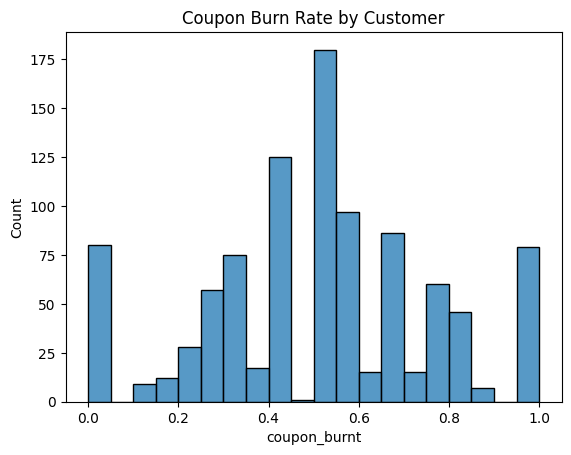

In [ ]:
customer_burn_rate = df.groupby('customer_id')['coupon_burnt'].mean()
sns.histplot(customer_burn_rate, bins=20)
plt.title('Coupon Burn Rate by Customer')
plt.show()

In [ ]:
X = df.drop('customer_id', axis=1)
X.shape

(5000, 8)

In [ ]:
X = X.select_dtypes(include=[np.number])


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:


k_range = range(2, 15)
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in k_range]
inertias = [model.inertia_ for model in kmeans_per_k]



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

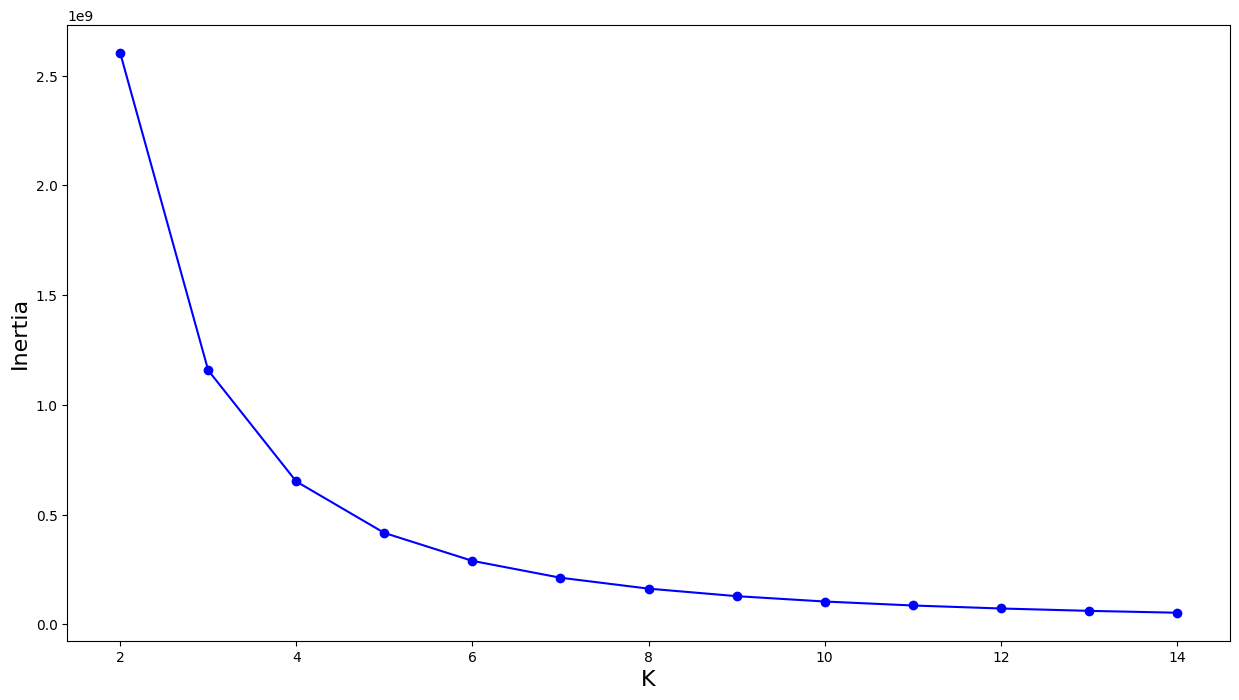

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('K', fontsize=16)
plt.ylabel('Inertia', fontsize=16)
plt.show()

In [ ]:


silhouette_scores = [silhouette_score(X_scaled, model.labels_)
                      for model in kmeans_per_k]

In [ ]:
best_index = np.argmax(silhouette_scores)
best_k = k_range[best_index]
best_score = silhouette_scores[best_index]
# Best number of clusters
best_k

2

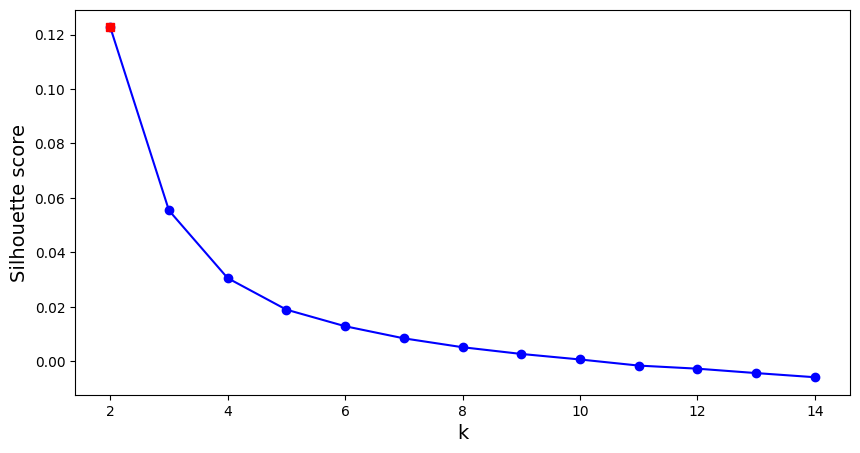

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(2, 15), silhouette_scores, "bo-")
plt.xlabel("k", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.plot(best_k, best_score, 'rs')
plt.show()

In [ ]:
best_model = kmeans_per_k[best_index]
best_model

KMeans(n_clusters=2, random_state=42)

In [ ]:
y_pred = best_model.fit_predict(X_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
for i in range(best_k):
    print(f"cluster {i + 1} contains: {np.sum(y_pred == i)} customers")

cluster 1 contains: 2433 customers
cluster 2 contains: 2567 customers


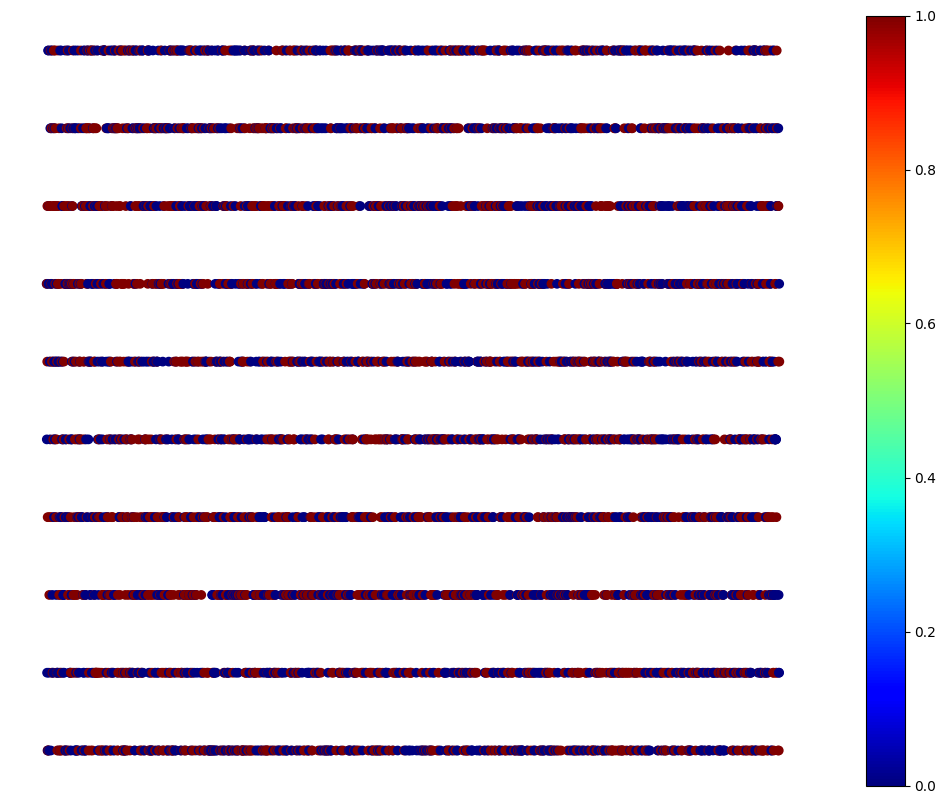

In [ ]:
plt.figure(figsize=(13,10 ))
plt.scatter(X_scaled[:, 0],X_scaled[:, 1],c=y_pred, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()